# patch hist


i hate drab and gloomy images, i like bright and colorful images, that was the first reason i wanted to try and make "patch hist". in this work i want to explore image manipulations that gives the image the most and best colors while preserving the image content.


For this i decided to take the route of histogram manipulation. In the area of histogram manipulation i decided that the ideas of histogram equalization is the best answer to the task of giving the image the most colors it can have while preserving the image content.

While basic histogram equalization gives us the answer globally, i would like it more if every part of the image would have our desired qualities on his own. So from this we come to "patch hist" which entails preforming histogram equalization on every patch of the image and blending the results. 
In essence what i try to do is to maximize the dynamic range in each sub-patch of the image.
There was a previous algorithm to try and make these results called CLAHE (Contrast-limited adaptive histogram equalization), but being from 1994 things where needed to be done to consider the limits of the computing power back then, and i believe that "patch hist" is closer to the true answer if computing power is not a problem.

In this work i will compere basic histogram equalization, CLAHE and my "patch hist".

For a representing sample 4 typical image categories were sampled from: selfie, full body, house and landscape.

## load the image

In [103]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import math
import seaborn as sns
%matplotlib inline

# from IPython.display import Image

figsize = (10,10)


In [104]:
# image_name = 'selfie'
# image_name = 'full body'
# image_name = 'house'
image_name = 'landscape'

img = cv2.imread(image_name+'.jpg')
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img0 = cv2.imread(image_name+'.jpg',0)
img0l = img_lab[:,:,0]

(944, 1400, 3)


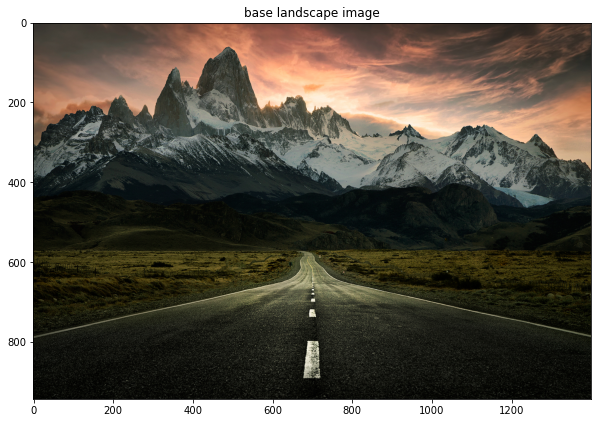

In [105]:
print(img.shape)

figsize = (10,10)
plt.figure(figsize=figsize)

plt.title(f"base {image_name} image")

# plt.imshow(img0,cmap='gray')
# plt.imshow(img0.astype(float) - img0l.astype(float),cmap='gray')
plt.imshow(img)
# plt.imshow(cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB))
plt.show()

## load the image manipulation code

the codes are written such that CLAHE and "patch hist" will work on the same patch size(as close as possible) 

In [106]:

def patch_hist1(img, use_tile_size = True, tile_size = [32,32], grid_size = [8,8]):
    """
    do the new "patch hist" adaptive histogram equalization transformation
    """
    
    S = img.shape
    
    # calculate the patch size
    if use_tile_size:
        tile = tile_size
        
    else:
        tile = (round(S[0]/grid_size[0]) ,round(S[1]/grid_size[1]))

    print(tile)

    # initialize the output image and tiles count
    tiles_count = np.zeros(S)
    img_ph = np.zeros(S)

    # do histogram equalization on each patch and average the results

    # for i in range(round(S[0]-tile[0]/2)):
    #     for j in range(round(S[1]-tile[1]/2)):
    #         tiles_count[i:i+tile[0],j:j+tile[1]] = tiles_count[i:i+tile[0],j:j+tile[1]]+1

    # for i in range(2*tile[0]):
    # for i in range(S[0]-2*tile[0],S[0]):
    for i in range(S[0]):
        # for j in range(2*tile[1]):
        # for j in range(S[1]-2*tile[1],S[1]):
        for j in range(S[1]):
            # calculate patch range
            x_min = max(0,math.ceil(i-tile[0]/2))
            x_max = min(S[0],math.ceil(i+tile[0]/2))
            y_min = max(0,math.ceil(j-tile[1]/2))
            y_max = min(S[1],math.ceil(j+tile[1]/2))
            # print(x_min, " , ",x_max, " , ",y_min, " , ",y_max)

            tiles_count[x_min:x_max,y_min:y_max] += 1
            # print(tiles_count[x_min:x_max,y_min:y_max].shape)

            # do histogram equalization on the patch
            img_ph[x_min:x_max,y_min:y_max] += cv2.equalizeHist(img[x_min:x_max,y_min:y_max])

    # average the results
    img_ph = img_ph/tiles_count


    
    return img_ph, tiles_count



In [107]:


def manipulate1(img, use_tile_size = True, tile_size = [32,32], grid_size = [8,8], show_img = True, figsize = (20,10), msg = None, dict_output = True):
    """
    do the three manipulations for the "patch hist" work on a gray-scale layer
    hist - image affter histogram equalization
    cl - image affter CLAHE
    img_ph -  image affter "patch hist"
    img_dict - dictionary of all images transformations
    tiles_count - map of tile count 
    """

    img_dict = {'original_img': img}
    
    S = img.shape

    # do histogram equalization
    hist = cv2.equalizeHist(img)
    img_dict['hist'] = hist

    # do adaptive histogram equalization
    # create a CLAHE object (Arguments are optional).
    # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    if use_tile_size:
        clahe = cv2.createCLAHE(tileGridSize=(round(S[0])/tile_size[0], round(S[1])/tile_size[1]))
    else:
        tuple
        clahe = cv2.createCLAHE(tileGridSize=tuple(grid_size))
        
    cl = clahe.apply(img)
    img_dict['CLAHE'] = cl

    # do the new "patch hist" adaptive histogram equalization
    img_ph, tiles_count = patch_hist1(img, use_tile_size = use_tile_size, tile_size = tile_size, grid_size = grid_size)
    img_dict['patch hist'] = img_ph

    # show the images if asked for

    if show_img:
        # img_dict = {'original_img': img, 'hist': hist, 'CLAHE': cl, 'patch hist': img_ph}
        # show_images1(img_dict, figsize = figsize, msg = msg)
        show_images2(img_dict, figsize = figsize, msg = msg)

    if dict_output:
        return img_dict, tiles_count
    if not dict_output:
        return hist, cl, img_ph, tiles_count




In [108]:
def show_images1(img_dict, figsize = (20,10), msg = None):
    """
    show all images as one image side by side
    """
    n = len(img_dict)
    
    print(msg)

    # fig, ax = plt.subplots(nrows=1, ncols=n, figsize=figsize)
    
    res = np.hstack([img_dict[img] for img in img_dict]) #stacking images side-by-side
    S = res.shape
    # print(res)
    # res = np.hstack((img, hist, cl, img_ph)) #stacking images side-by-side
    print(res.shape)

    figsize = (40,10)
    plt.figure(figsize=figsize)
    plt.title(msg)

    if S[-1] == 3:
        plt.imshow(res)
    else:
        plt.imshow(res,cmap='gray')
        
    plt.show()




In [109]:
def show_images2(img_dict, figsize = (20,10), msg = None):
    """
    show all images separately side by side with their title
    """

    n = len(img_dict)
    
    print(msg)

    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=figsize, sharex=True, sharey=True)
    # ax.set_ylabel(title)

    
    for ind,title in enumerate(img_dict):
        ax[ind].imshow(img_dict[title])
        ax[ind].set_title(title)
        ax[ind].set_ylabel(msg)
        # ax[ind].set_axis_off()
    plt.tight_layout() # optional
        
    plt.show()




In [110]:
def show_histograms1(img_dict, bins=256, figsize = (20,5), msg = None, use_lab = False):
    """
    show the histograms of all of the images
    score by histogram smoothness - calculated as the standard deviation of the histogram bins sizes (normalize by mean bin size)
    
    """

    scores = {}

    n = len(img_dict)
    
    print(msg)

    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=figsize, sharex=True, sharey=True)

    
    for ind,title in enumerate(img_dict):
        # ax[ind].imshow(img_dict[title])
        S = img_dict[title].shape
        print(S)
        
        scores[title] = []
        ax[ind].set_ylabel(msg)

        # normal RGB images
        if S[-1] == 3 and use_lab == False:
            color = ('r','g','b')
            for i,col in enumerate(color):
                histr = cv2.calcHist([img_dict[title]],[i],None,[bins],[0,256])
                # print(histr.std() / histr.mean())
                scores[title].append(histr.std() / histr.mean())
                ax[ind].plot(histr,color = col)
                ax[ind].set_title(title)
        # lab images
        if S[-1] == 3 and use_lab == True:
            img = cv2.cvtColor(img_dict[title], cv2.COLOR_RGB2LAB)
            histr = ax[ind].hist(img[:,:,0].ravel(), bins=bins)
            # histr = cv2.calcHist([img],[0],None,[bins],[0,256])
            # print(len(histr))
            # print(len(histr[0]))
            # print(histr[0].std() / histr[0].mean())
            scores[title].append(histr[0].std() / histr[0].mean())
            # ax[ind].plot(histr)
            ax[ind].set_title(title)
        # grayscale images
        if S[-1] == 1 or len(S) == 2:
            # ax[ind].hist(img_dict[title].flat, bins=bins, range=(0, 255))
            histr = ax[ind].hist(img_dict[title].ravel(), bins=bins)
            # print(histr[0].std() / histr[0].mean())
            scores[title].append(histr[0].std() / histr[0].mean())
            ax[ind].set_title(title)
            # ax[ind].set_axis_off()
    plt.tight_layout() # optional
        
    plt.show()

    return scores



In [111]:

def manipulate1_lab(img, use_tile_size_c = True, tile_size_c = [32,32], grid_size_c = [8,8], show_img = True, figsize = (20,10), img_is_rgb = True, msg = None, dict_output = True):
    """
    get a LAB color image, or transform a RGB color image to a LAB color image
    and do all of the manipulations on the L layer of the image.
    """
    # if the image is a RGB color image change it to a LAB color image
    if img_is_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    S = img.shape

    # hist = np.zeros(S)
    # cl = np.zeros(S)
    # img_ph = np.zeros(S)

    hist = img.copy()
    cl = img.copy()
    img_ph = img.copy()
    
    # do the manipulations on the L image layer
    hist[:,:,0], cl[:,:,0], img_ph[:,:,0], tiles_count = manipulate1(img[:,:,0], use_tile_size=use_tile_size_c, tile_size=tile_size_c, grid_size=grid_size_c, show_img=False, dict_output = False)

    # turn images back from LAB color space to a RGB color image
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    # hist[:,:,1:3] = img[:,:,1:3]
    hist = cv2.cvtColor(hist, cv2.COLOR_LAB2RGB)
    # cl[:,:,1:3] = img[:,:,1:3]
    cl = cv2.cvtColor(cl, cv2.COLOR_LAB2RGB)
    # img_ph[:,:,1:3] = img[:,:,1:3]
    img_ph = cv2.cvtColor(img_ph, cv2.COLOR_LAB2RGB)

    # show images if wanted
    if show_img:
        img_dict = {'original_img': img, 'hist': hist, 'CLAHE': cl, 'patch hist': img_ph}
        # show_images1(img_dict, figsize = figsize, msg = msg)
        show_images2(img_dict, figsize = figsize, msg = msg)


    if dict_output:
        return img_dict, tiles_count
    if not dict_output:
        return hist, cl, img_ph, tiles_count



In [112]:

def manipulate1_lab2(img, use_tile_size_c = True, tile_size_c = [32,32], grid_size_c = [8,8], show_img = True, figsize = (20,10), img_is_rgb = True, msg = None, dict_output = True):
    """
    get a LAB color image, or transform a RGB color image to a LAB color image
    and do all of the manipulations on the all of the layers of the image separately.
    """
    # if the image is a RGB color image change it to a LAB color image
    if img_is_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    S = img.shape

    # hist = np.zeros(S)
    # cl = np.zeros(S)
    # img_ph = np.zeros(S)

    hist = img.copy()
    cl = img.copy()
    img_ph = img.copy()
    
    # do the manipulations on the L A and B image layers
    for i in range(S[-1]):
        hist[:,:,i], cl[:,:,i], img_ph[:,:,i], tiles_count = manipulate1(img[:,:,i], use_tile_size=use_tile_size_c, tile_size=tile_size_c, grid_size=grid_size_c, show_img=False, dict_output = False)

    # turn images back from LAB color space to a RGB color image
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    # hist[:,:,1:3] = img[:,:,1:3]
    hist = cv2.cvtColor(hist, cv2.COLOR_LAB2RGB)
    # cl[:,:,1:3] = img[:,:,1:3]
    cl = cv2.cvtColor(cl, cv2.COLOR_LAB2RGB)
    # img_ph[:,:,1:3] = img[:,:,1:3]
    img_ph = cv2.cvtColor(img_ph, cv2.COLOR_LAB2RGB)


    # show images if wanted
    if show_img:
        img_dict = {'original_img': img, 'hist': hist, 'CLAHE': cl, 'patch hist': img_ph}
        # show_images1(img_dict, figsize = figsize, msg = msg)
        show_images2(img_dict, figsize = figsize, msg = msg)


    if dict_output:
        return img_dict, tiles_count
    if not dict_output:
        return hist, cl, img_ph, tiles_count



In [113]:

def manipulate1_color(img, use_tile_size_c = True, tile_size_c = [32,32], grid_size_c = [8,8], show_img = True, figsize = (20,10), msg = None, dict_output = True):
    """
    get a RGB color image, or GrayScale image
    and do all of the manipulations on the all of the layers of the image separately.
    """
    
    S = img.shape

    # hist = np.zeros(S)
    # cl = np.zeros(S)
    # img_ph = np.zeros(S)
    
    hist = img.copy()
    cl = img.copy()
    img_ph = img.copy()

    # do the manipulations on all image layers   
    if len(S) == 3:
        for i in range(S[-1]):
            hist[:,:,i], cl[:,:,i], img_ph[:,:,i], tiles_count = manipulate1(img[:,:,i], use_tile_size=use_tile_size_c, tile_size=tile_size_c, grid_size=grid_size_c, show_img=False, dict_output = False)
    elif len(S) == 2:
        hist, cl, img_ph, tiles_count = manipulate1(img, use_tile_size=use_tile_size_c, tile_size=tile_size_c, grid_size=grid_size_c, show_img=False, dict_output = False)


    # show images if wanted
    if show_img:
        img_dict = {'original_img': img, 'hist': hist, 'CLAHE': cl, 'patch hist': img_ph}
        # show_images1(img_dict, figsize = figsize, msg = msg)
        show_images2(img_dict, figsize = figsize, msg = msg)


    if dict_output:
        return img_dict, tiles_count
    if not dict_output:
        return hist, cl, img_ph, tiles_count



### show LAB color manipulation
use lab-color image as input and work only on the L image layer

(118, 175)
landscape LAB transformions


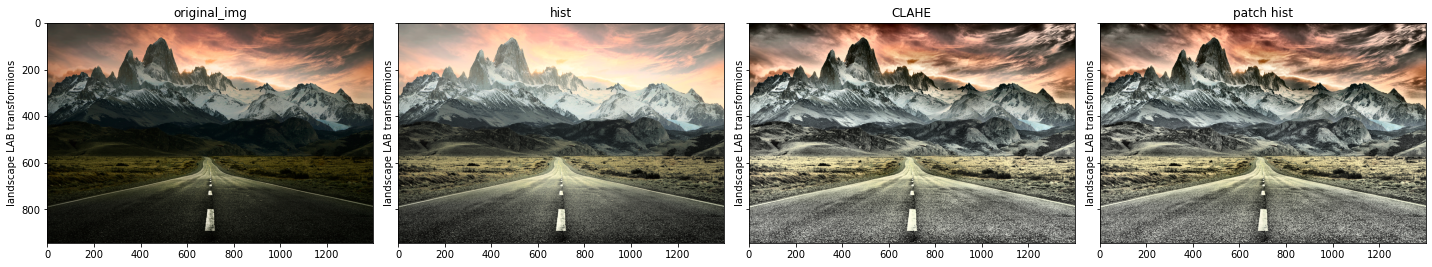

In [114]:
# hist2, cl2, img_ph2, tiles_count = manipulate1_lab(img_lab, use_tile_size_c=False, grid_size_c=[8,8], show_img = True, img_is_rgb=False)
img_dict1, tiles_count = manipulate1_lab(img_lab, use_tile_size_c=False, grid_size_c=[8,8], show_img = True, img_is_rgb=False, msg = image_name+" LAB transformions")

# hist2, cl2, img_ph2, tiles_count = manipulate1_lab(img_lab, use_tile_size_c=False, grid_size_c=[4,4], show_img = True)

In [115]:
# hist2, cl2, img_ph2, tiles_count = manipulate1_lab2(img_lab, use_tile_size_c=False, grid_size_c=[8,8], show_img = True)
# img_dict2, tiles_count = manipulate1_lab2(img_lab, use_tile_size_c=False, grid_size_c=[8,8], show_img = True, msg = image_name+" full LAB transformions")
# hist2, cl2, img_ph2, tiles_count = manipulate1_lab2(img_lab, use_tile_size_c=False, grid_size_c=[4,4], show_img = True)

### show RGB color manipulation
use rgb-color image as input and work on all layers separately

(118, 175)
(118, 175)
(118, 175)
landscape RGB transformions


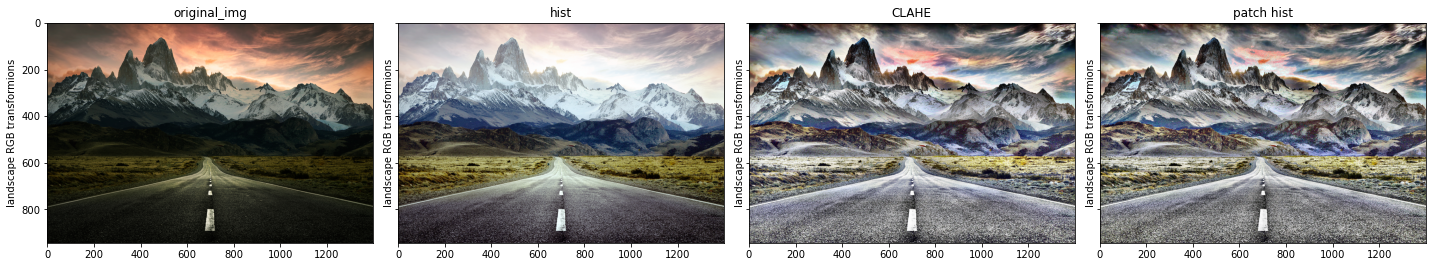

In [116]:
# hist3, cl3, img_ph3, tiles_count = manipulate1_color(img, use_tile_size_c=False, grid_size_c=[8,8], show_img = True)
img_dict3, tiles_count = manipulate1_color(img, use_tile_size_c=False, grid_size_c=[8,8], show_img = True, msg = image_name+" RGB transformions")
# hist3, cl3, img_ph3, tiles_count = manipulate1_color(img, use_tile_size_c=False, grid_size_c=[4,4], show_img = True)

from the results it looks like the LAB manipulation look more natural and easier on the eyes, and the RGB manipulation may look more artistic and colorful.

These results may come from the theory of light, that says that light have 3 parameters: amplitude(strength), wavelength(color) and polarization(that normal cameras don't measure).
so doing the LAB manipulation works on equalizing amplitudes as a whole,
while doing the RGB manipulation works on equalizing amplitudes of specific wavelengths.

<!-- so from now i will continue working on the LAB manipulation -->


## Lets see how the histograms look

histograms scores are given as the standard deviation of the histogram bins sizes (normalize by mean bin size).


### histograms of the LAB manipulations


landscape LAB histograms in LAB space
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)


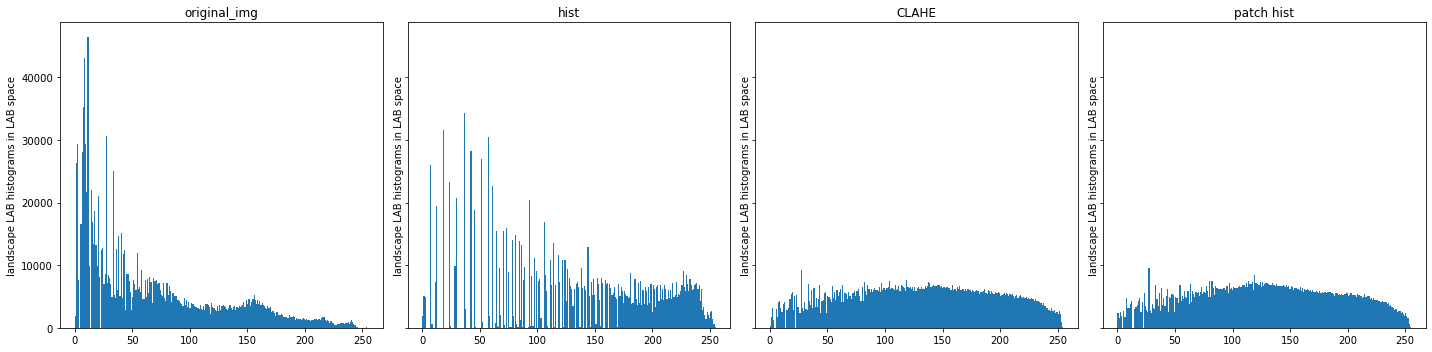

{'original_img': [1.2757327737454527], 'hist': [1.154441256128386], 'CLAHE': [0.29849611279563265], 'patch hist': [0.312950941110327]}


In [117]:

scores = show_histograms1(img_dict1, bins=256, figsize = (20,5), msg = image_name+" LAB histograms in LAB space", use_lab = True)
print(scores)


landscape LAB histograms in RGB space
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)


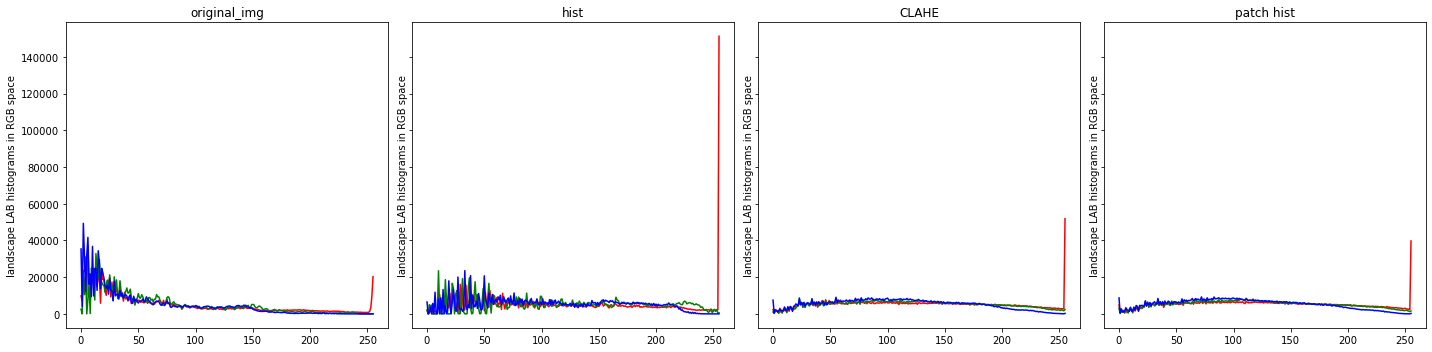

{'original_img': [1.0880476, 1.1247098, 1.4273357], 'hist': [1.8267477, 0.67762226, 0.6771148], 'CLAHE': [0.61914515, 0.32645077, 0.48307875], 'patch hist': [0.49223813, 0.34233597, 0.49325204]}


In [118]:

scores = show_histograms1(img_dict1, bins=256, figsize = (20,5), msg = image_name+" LAB histograms in RGB space", use_lab = False)
print(scores)


### histograms of the RGB manipulations


landscape RGB histograms in LAB space
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)


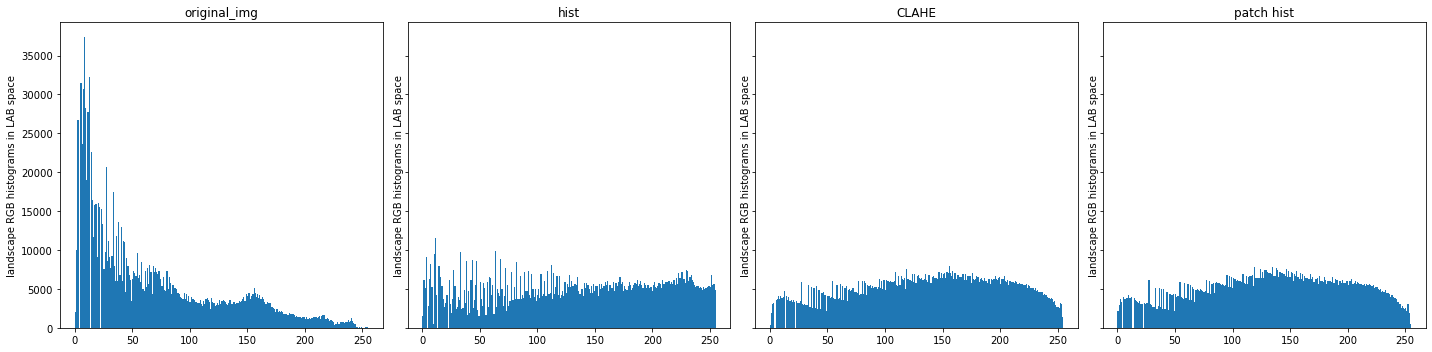

{'original_img': [1.172096515356124], 'hist': [0.3163984379766023], 'CLAHE': [0.28061545882816147], 'patch hist': [0.29433779996163395]}


In [119]:

scores = show_histograms1(img_dict3, bins=256, figsize = (20,5), msg = image_name+" RGB histograms in LAB space", use_lab = True)
print(scores)


landscape RGB histograms in RGB space
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)


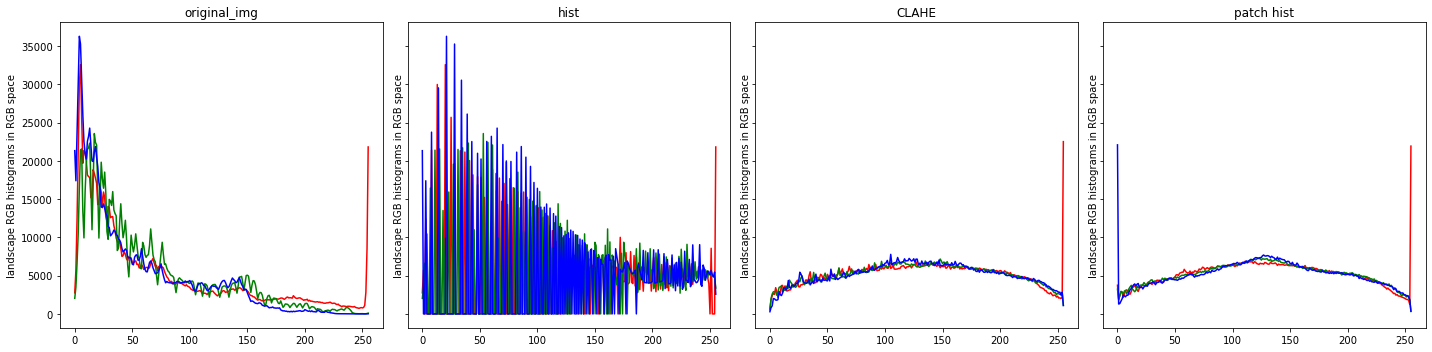

{'original_img': [1.0597273, 1.0436568, 1.2941239], 'hist': [1.1365395, 1.1041607, 1.3336961], 'CLAHE': [0.31881455, 0.23869422, 0.26458448], 'patch hist': [0.3321455, 0.26011604, 0.34795547]}


In [120]:

scores = show_histograms1(img_dict3, bins=256, figsize = (20,5), msg = image_name+" RGB histograms in RGB space", use_lab = False)
print(scores)


for now it looks like CLAHE gives the smoothest histogram and first version of "patch hist" is a little rougher than it, 
but both do much better job then global histogram equalization.
and (at least to me) CLAHE and "patch hist" emphasize the most details in the image

In [121]:

# img_dict = {'original_img': img, 'hist': hist2, 'CLAHE': cl2, 'patch hist': img_ph2}
# img_dict = {'original_img': img/256, 'hist': hist3/256, 'CLAHE': cl3/256, 'patch hist': img_ph3/256}
# show_images1(img_dict1, figsize = (20,20), msg = "test")
# show_images2(img_dict1, figsize = (20,10), msg = "test")

# S = img_dict.keys()
# S

# histogram
# scores = show_histograms1(img_dict1, bins=256, figsize = (20,5), msg = image_name+" LAB histograms", use_lab = True)
# print(scores)
# scores = show_histograms1(img_dict3, bins=256, figsize = (20,5), msg = image_name+" RGB histograms", use_lab = False)
# print(scores)



## bonus materials 



because "patch hist" works on every patch in the image, it have many data points on each pixel, so we can calculate more then just the mean of the distribution.

lets try and see how the standard deviation and skewness looks like.


### make standard deviation and skewness images

In [122]:

def patch_hist2(original_image, patch_hist_image, use_tile_size = True, tile_size = [32,32], grid_size = [8,8]):
    """
    do the new "patch hist" adaptive histogram equalization transformation to get the standard deviation and skewness results
    original_image - the original image
    patch_hist_image - the normal (mean) "patch hist" image

    img_std_ph - output image of the standard deviation
    img_skew_ph - output image of the skewness
    """
    
    S = original_image.shape
    
    # calculate the patch size
    if use_tile_size:
        tile = tile_size
        
    else:
        tile = (round(S[0]/grid_size[0]) ,round(S[1]/grid_size[1]))

    print(tile)

    # initialize the output image and tiles count
    tiles_count = np.zeros(S)
    img_std_ph = np.zeros(S)
    img_skew_ph = np.zeros(S)

    # do histogram equalization on each patch and calculate the standard deviation and skewness results

    # for i in range(round(S[0]-tile[0]/2)):
    #     for j in range(round(S[1]-tile[1]/2)):
    #         tiles_count[i:i+tile[0],j:j+tile[1]] = tiles_count[i:i+tile[0],j:j+tile[1]]+1

    # for i in range(2*tile[0]):
    # for i in range(S[0]-2*tile[0],S[0]):
    for i in range(S[0]):
        # for j in range(2*tile[1]):
        # for j in range(S[1]-2*tile[1],S[1]):
        for j in range(S[1]):
            # calculate patch range
            x_min = max(0,math.ceil(i-tile[0]/2))
            x_max = min(S[0],math.ceil(i+tile[0]/2))
            y_min = max(0,math.ceil(j-tile[1]/2))
            y_max = min(S[1],math.ceil(j+tile[1]/2))
            # print(x_min, " , ",x_max, " , ",y_min, " , ",y_max)

            tiles_count[x_min:x_max,y_min:y_max] += 1
            # print(tiles_count[x_min:x_max,y_min:y_max].shape)

            # do histogram equalization on the patch
            temp = cv2.equalizeHist(original_image[x_min:x_max,y_min:y_max]).astype(float)

            # img_ph[x_min:x_max,y_min:y_max] += cv2.equalizeHist(original_image[x_min:x_max,y_min:y_max])
            img_std_ph[x_min:x_max,y_min:y_max] += (temp - patch_hist_image[x_min:x_max,y_min:y_max])**2
            img_skew_ph[x_min:x_max,y_min:y_max] += (temp - patch_hist_image[x_min:x_max,y_min:y_max])**3

    # average the results
    # img_std_ph = (img_std_ph/tiles_count)**0.5
    img_std_ph = np.sqrt(img_std_ph/tiles_count)
    for i in range(S[0]):
        for j in range(S[1]):
            if img_std_ph[i][j] == 0:
                img_skew_ph[i][j] == 0
            else:
                # img_skew_ph[i][j] = ((img_skew_ph[i][j]/(img_std_ph[i][j]**3))/tiles_count[i][j])**(1/3)
                img_skew_ph[i][j] = np.cbrt((img_skew_ph[i][j]/(img_std_ph[i][j]**3))/tiles_count[i][j])
    # img_skew_ph = ((img_skew_ph/(img_std_ph**3))/tiles_count)**(1/3)
    # img_skew_ph = np.cbrt((img_skew_ph/(img_std_ph**3))/tiles_count)
    # img_ph = img_ph/tiles_count


    
    return img_std_ph, img_skew_ph, tiles_count



making the images for the LAB "patch hist" case

In [123]:
# turn the "patch hist" on the LAB color space to LAB color space 
img_ph_lab = cv2.cvtColor(img_dict1["patch hist"], cv2.COLOR_RGB2LAB)

img_std_ph, img_skew_ph, tiles_count = patch_hist2(img_lab[:,:,0], img_ph_lab[:,:,0], use_tile_size=False, grid_size=[8,8])


(118, 175)


showing the resulted images and their histograms

In [124]:
def show_images2_1(img_dict, figsize = (20,10), cmap=None, msg = None):
    """
    show all images separately side by side with their title
    """

    n = len(img_dict)
    
    print(msg)

    min = 10**5
    max = -10**5
    for ind,title in enumerate(img_dict):
        if img_dict[title].min() < min:
            min = img_dict[title].min()
        if img_dict[title].max() > max:
            max = img_dict[title].max()

    print("the range is between {:.3f} to  {:.3f} ".format(min, max))
    full_title = msg + "\nthe range is between {:.3f} to  {:.3f} ".format(min, max)

    if n == 1:
        plt.figure(figsize=figsize)
        plt.imshow(img_dict[title], cmap=cmap)
        plt.title(full_title)
        plt.ylabel(msg)
        plt.colorbar()

    

    if n > 1:
        fig, ax = plt.subplots(nrows=1, ncols=n, figsize=figsize, sharex=True, sharey=True)
        for ind,title in enumerate(img_dict):
            img = (img_dict[title] - min) / (max - min)
            print(img.min())
            print(img.max())
            print(img.shape)
            ax[ind].imshow(img)
            ax[ind].set_title(title)
            # ax[ind].colorbar()
            ax[ind].set_ylabel(msg)
            # ax[ind].set_axis_off()
        plt.tight_layout() # optional
        
    plt.show()




In [125]:
def show_histograms1_1(img_dict, bins=256, figsize = (20,5), msg = None, use_lab = False):
    """
    show the histograms of all of the images
    score by histogram smoothness - calculated as the standard deviation of the histogram bins sizes (normalize by mean bin size)
    
    """

    scores = {}

    n = len(img_dict)
    
    print(msg)

    min = 10**5
    max = -10**5
    for ind,title in enumerate(img_dict):
        if img_dict[title].min() < min:
            min = img_dict[title].min()
        if img_dict[title].max() > max:
            max = img_dict[title].max()

    print("the range is between {:.3f} to  {:.3f} ".format(min, max))
    full_title = msg + "\nthe range is between {:.3f} to  {:.3f} ".format(min, max)

    if n == 1:
        plt.figure(figsize=figsize)
        S = img_dict[title].shape
        print(S)
        
        scores[title] = []
        plt.ylabel(msg)

        # normal RGB images
        if S[-1] == 3 and use_lab == False:
            color = ('r','g','b')
            for i,col in enumerate(color):
                histr = cv2.calcHist([img_dict[title]],[i],None,[bins],[img_dict[title].min(),img_dict[title].max()])
                # print(histr.std() / histr.mean())
                scores[title].append(histr.std() / histr.mean())
                plt.plot(histr,color = col)
                plt.title(full_title)
        # lab images
        if S[-1] == 3 and use_lab == True:
            img = cv2.cvtColor(img_dict[title], cv2.COLOR_RGB2LAB)
            histr = plt.hist(img[:,:,0].ravel(), bins=bins)
            # histr = cv2.calcHist([img],[0],None,[bins],[0,256])
            # print(len(histr))
            # print(len(histr[0]))
            # print(histr[0].std() / histr[0].mean())
            scores[title].append(histr[0].std() / histr[0].mean())
            # plt.plot(histr)
            plt.title(full_title)
        # grayscale images
        if S[-1] == 1 or len(S) == 2:
            # plt.hist(img_dict[title].flat, bins=bins, range=(0, 255))
            histr = plt.hist(img_dict[title].ravel(), bins=bins)
            # print(histr[0].std() / histr[0].mean())
            scores[title].append(histr[0].std() / histr[0].mean())
            plt.title(full_title)
            # plt.axis_off()
        plt.tight_layout() # optional
            
        plt.show()

        return scores    
    
    
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=figsize, sharex=True, sharey=True)
    
    for ind,title in enumerate(img_dict):
        # ax[ind].imshow(img_dict[title])
        S = img_dict[title].shape
        print(S)
        
        scores[title] = []
        ax[ind].set_ylabel(msg)

        # normal RGB images
        if S[-1] == 3 and use_lab == False:
            color = ('r','g','b')
            for i,col in enumerate(color):
                histr = cv2.calcHist([img_dict[title]],[i],None,[bins],[img_dict[title].min(),img_dict[title].max()])
                # print(histr.std() / histr.mean())
                scores[title].append(histr.std() / histr.mean())
                ax[ind].plot(histr,color = col)
                ax[ind].set_title(title)
        # lab images
        if S[-1] == 3 and use_lab == True:
            img = cv2.cvtColor(img_dict[title], cv2.COLOR_RGB2LAB)
            histr = ax[ind].hist(img[:,:,0].ravel(), bins=bins)
            # histr = cv2.calcHist([img],[0],None,[bins],[0,256])
            # print(len(histr))
            # print(len(histr[0]))
            # print(histr[0].std() / histr[0].mean())
            scores[title].append(histr[0].std() / histr[0].mean())
            # ax[ind].plot(histr)
            ax[ind].set_title(title)
        # grayscale images
        if S[-1] == 1 or len(S) == 2:
            # ax[ind].hist(img_dict[title].flat, bins=bins, range=(0, 255))
            histr = ax[ind].hist(img_dict[title].ravel(), bins=bins)
            # print(histr[0].std() / histr[0].mean())
            scores[title].append(histr[0].std() / histr[0].mean())
            ax[ind].set_title(title)
            # ax[ind].set_axis_off()
    plt.tight_layout() # optional
        
    plt.show()

    return scores



#### standard deviation

In [126]:
print("the max of the standard deviation image is : {:.3f}".format(img_std_ph.max()))
print("the min of the standard deviation image is : {:.3f}".format(img_std_ph.min()))
print("the mean of the standard deviation image is : {:.3f}".format(img_std_ph.mean()))

the max of the standard deviation image is : 72.481
the min of the standard deviation image is : 0.000
the mean of the standard deviation image is : 29.208


landscape standard deviation image of LAB "patch hist1"
the range is between 0.000 to  72.481 


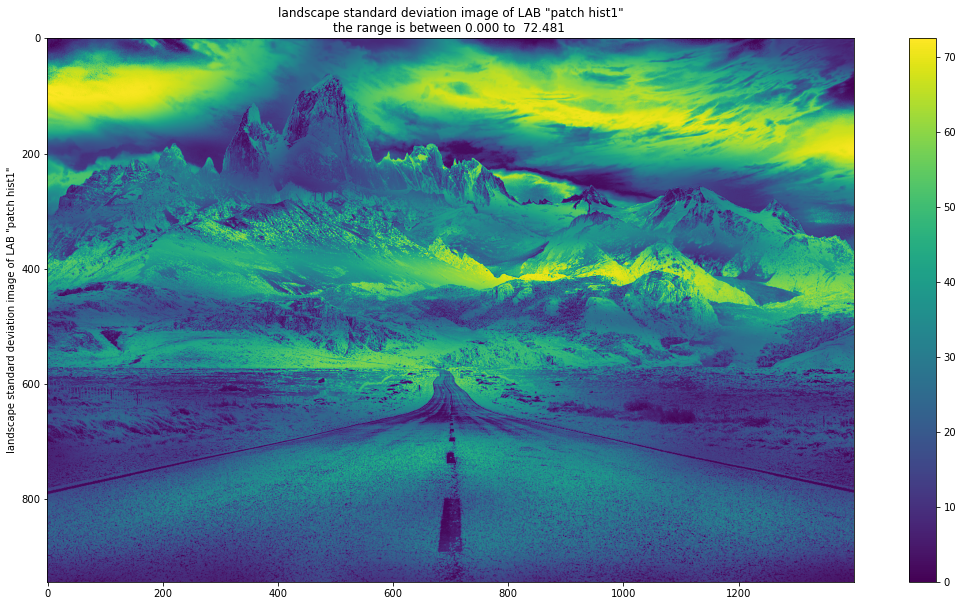

In [127]:
# the image of the standard deviation image

show_images2_1({"img_std_ph": img_std_ph}, figsize = (20,10), cmap=None, msg = image_name + ' standard deviation image of LAB "patch hist1"')
# show_images2_1({"img_std_ph": img_std_ph}, figsize = (20,10), cmap='gray', msg = image_name + ' standard deviation image of LAB "patch hist1"')


landscape standard deviation histogram of LAB "patch hist1"
the range is between 0.000 to  72.481 
(944, 1400)


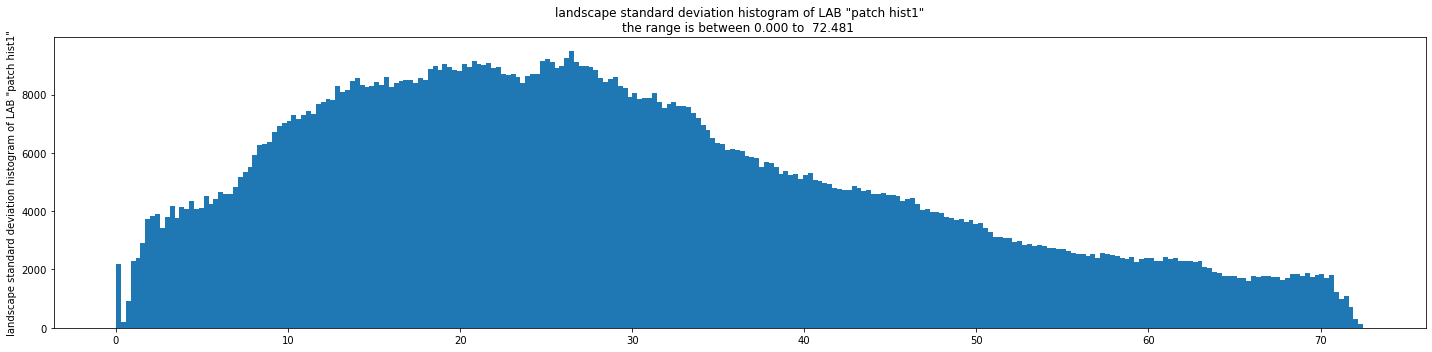

{'img_std_ph': [0.5120582003987958]}

In [128]:
# the histogram of the standard deviation image

show_histograms1_1({"img_std_ph": img_std_ph}, bins=256, figsize = (20,5), msg = image_name + ' standard deviation histogram of LAB "patch hist1"')



it looks like the "patch hist" results are not completely stable from seeing the results of its standard deviation


#### skewness

In [129]:
print("the max of the skewness image is : {:.3f}".format(img_skew_ph.max()))
print("the min of the skewness image is : {:.3f}".format(img_skew_ph.min()))
print("the mean of the skewness image is : {:.3f}".format(img_skew_ph.mean()))

the max of the skewness image is : 3.351
the min of the skewness image is : -1.757
the mean of the skewness image is : 0.106


landscape skewness image of LAB "patch hist1"
the range is between -1.757 to  3.351 


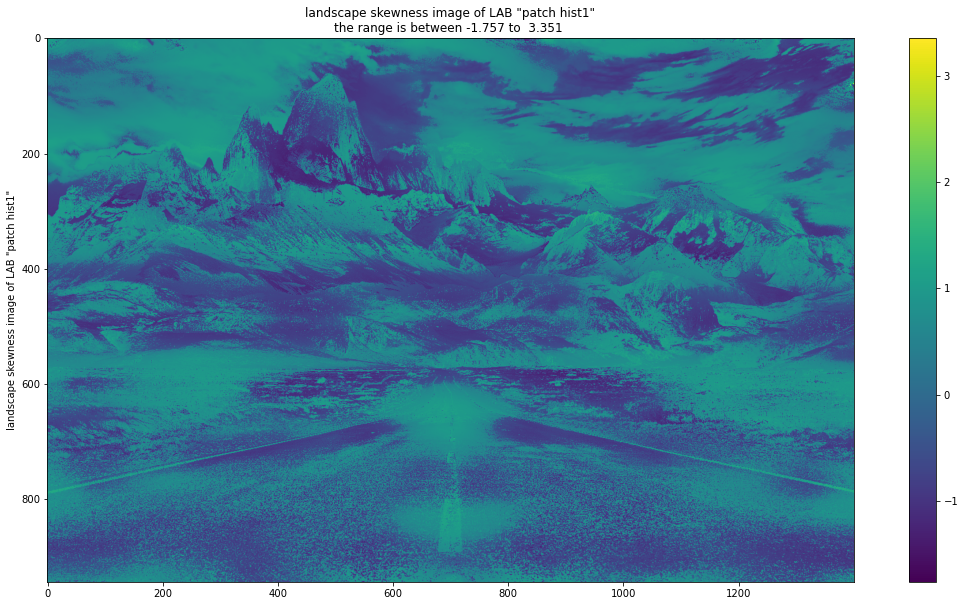

In [130]:
# the image of the skewness image

show_images2_1({"img_skew_ph": img_skew_ph}, figsize = (20,10), cmap=None, msg = image_name + ' skewness image of LAB "patch hist1"')
# show_images2_1({"img_skew_ph": img_skew_ph}, figsize = (20,10), cmap='gray', msg = image_name + ' skewness image of LAB "patch hist1"')


landscape skewness histogram of LAB "patch hist1"
the range is between -1.757 to  3.351 
(944, 1400)


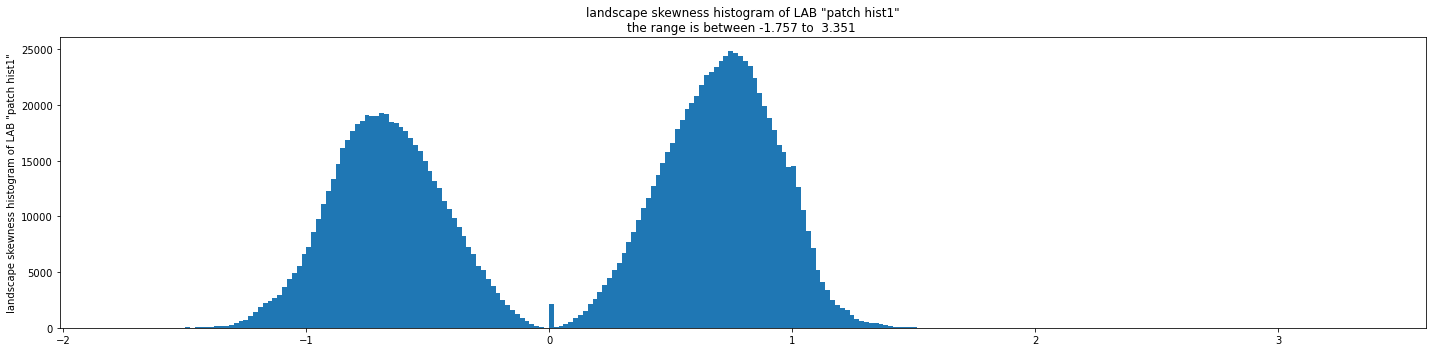

{'img_skew_ph': [1.4555566496417625]}

In [131]:
# the histogram of the skewness image

show_histograms1_1({"img_skew_ph": img_skew_ph}, bins=256, figsize = (20,5), msg = image_name + ' skewness histogram of LAB "patch hist1"')



<!-- it looks like the "patch hist" results tend to have more negative skewness results values and some positive skewness results values but less skewness values close to zero -->

it looks like the "patch hist" results tend to have negative skewness results values and positive skewness results values but less skewness values close to zero


#### standard deviation and skewness

let's see if the joint distribution of the standard deviation and the skewness show us something special

(944, 1400)
(1321600,)
(1321600,)
True


Text(0.5, 1.0, 'landscape standard deviation and skewness joint distribution of LAB "patch hist1"')

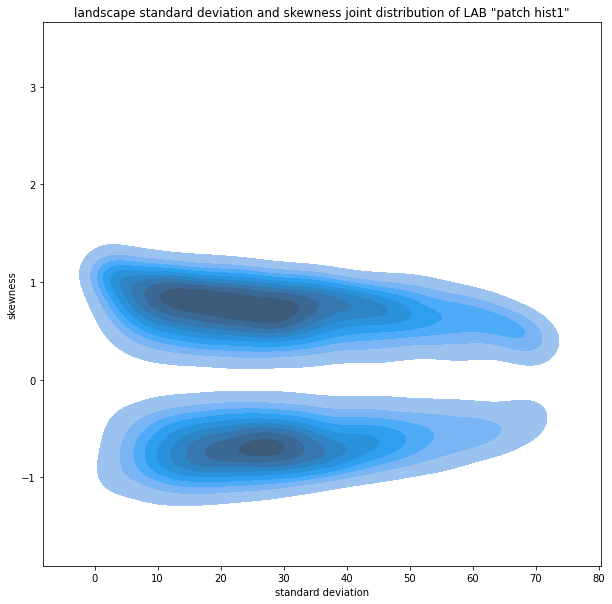

In [132]:

S = img_std_ph.shape

print(img_std_ph.shape)
print(img_std_ph.flatten().shape)
print(img_std_ph.ravel().shape)
print(all(img_std_ph.flatten()==img_std_ph.ravel()))

sd = img_std_ph.flatten()
# sd = img_std_ph.ravel()
skew = img_skew_ph.flatten()

data = pd.DataFrame()
data["standard deviation"] = sd
data["skewness"] = skew

plt.figure(figsize=(10,10))
sns.kdeplot(data=data.sample(50000), x="standard deviation", y="skewness", fill=True)
title = image_name + ' standard deviation and skewness joint distribution of LAB "patch hist1"'
plt.title(title)



In [133]:
# print("{:.3f}".format(img_std_ph.max()))
# print("{:.3f}".format(img_std_ph.min()))
# print("{:.3f}".format(img_std_ph.mean()))

# print("\n\n")

# print("{:.3f}".format(img_skew_ph.max()))
# print("{:.3f}".format(img_skew_ph.min()))
# print("{:.3f}".format(img_skew_ph.mean()))

#### skewness correction

having calculated the mean image as well as the standard deviation image and the skewness image,
we can now calculate a correction of the mean towards the median

In [134]:
def show_skew_correction(mean, std, skew, alphas, figsize = (20,10), msg = None):
    """
    use the mean std and skew images to show skew correction images with all alphas parameters
    """

    n = len(alphas)
    
    print(msg)

    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=figsize, sharex=True, sharey=True)
    # ax.set_ylabel(title)
    plt.title(msg)

    
    for ind,alpha in enumerate(alphas):
        img = mean.copy()
        print(img.shape)
        if len(img.shape) == 3:
            img[:, :, 0] = mean[:, :, 0] - alpha * skew * std
        if len(img.shape) == 2:
            img = mean - alpha * skew * std
        ax[ind].imshow(cv2.cvtColor(img, cv2.COLOR_LAB2RGB))
        ax[ind].set_title("alpha = "+str(alpha))
        # ax[ind].set_ylabel(msg)
        # ax[ind].set_axis_off()
    plt.tight_layout() # optional

 
    plt.show()




landscape skew correction of LAB "patch hist1"
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)
(944, 1400, 3)


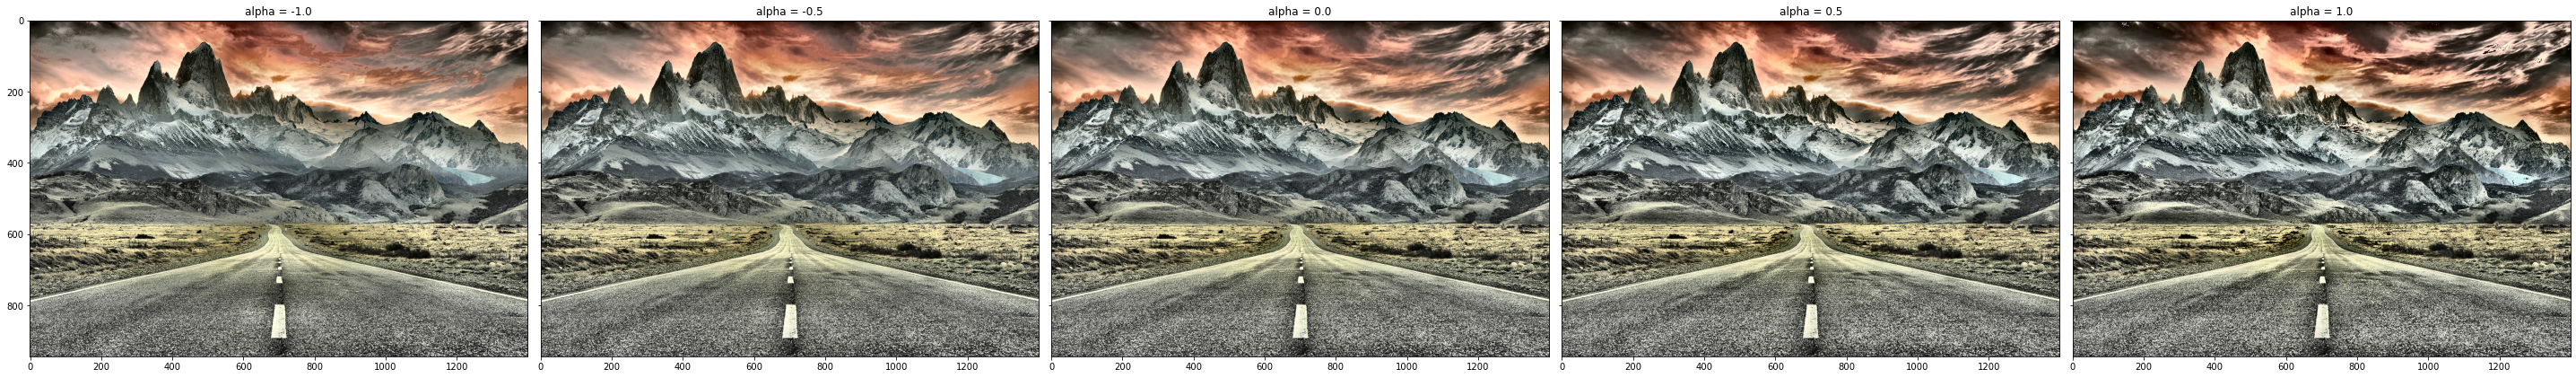

In [135]:

skew_corrected = img_ph_lab.copy()

img_mean_ph = img_ph_lab[:, :, 0].copy()
# img_std_ph
# img_skew_ph
img_mean_ph.shape

# alphas = np.arange(-0.5,0.6,0.25)
alphas = np.arange(-1,1.1,0.5)

show_skew_correction(skew_corrected, img_std_ph, img_skew_ph, alphas, figsize = (40,20), msg =  image_name + ' skew correction of LAB "patch hist1"')
